In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_128_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        82048     
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
activation_20 (Activation)   (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2133 - acc: 0.2809
Epoch 00001: val_loss improved from inf to 1.83101, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_3_conv_checkpoint/001-1.8310.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 2.2132 - acc: 0.2809 - val_loss: 1.8310 - val_acc: 0.3829
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5069 - acc: 0.5163
Epoch 00002: val_loss did not improve from 1.83101
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.5076 - acc: 0.5163 - val_loss: 1.9416 - val_acc: 0.3746
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2008 - acc: 0.6143
Epoch 00003: val_loss improved from 1.83101 to 1.26468, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_3_conv_checkpoint/003-1.2647.h

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1445 - acc: 0.9562
Epoch 00029: val_loss did not improve from 1.16013
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.1445 - acc: 0.9562 - val_loss: 1.5549 - val_acc: 0.6983
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1320 - acc: 0.9600
Epoch 00030: val_loss did not improve from 1.16013
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.1320 - acc: 0.9600 - val_loss: 1.6644 - val_acc: 0.6513
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1419 - acc: 0.9570
Epoch 00031: val_loss did not improve from 1.16013
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.1419 - acc: 0.9570 - val_loss: 1.7278 - val_acc: 0.6657
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1349 - acc: 0.9593
Epoch 00032: val_loss did not improve from 1.16013
36805/36805 [===========

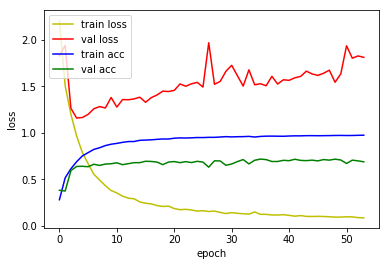

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.2997 - acc: 0.6075
Loss: 1.2996753081106818 Accuracy: 0.60747665

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2015 - acc: 0.2696
Epoch 00001: val_loss improved from inf to 2.20764, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_4_conv_checkpoint/001-2.2076.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 2.2014 - acc: 0.2696 - val_loss: 2.2076 - val_acc: 0.3280
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5245 - acc: 0.5051
Epoch 00002: val_loss improved from 2.20764 to 1.50156, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_4_conv_checkpoint/002-1.5016.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.5244 - acc: 0.5051 - val_loss: 1.5016 - val_acc: 0.5013
Epoch 3/500
36800/36805 [============================>.]

36800/36805 [============================>.] - ETA: 0s - loss: 2.7204 - acc: 0.0811
Epoch 00027: val_loss did not improve from 0.80319
36805/36805 [==============================] - 65s 2ms/sample - loss: 2.7204 - acc: 0.0811 - val_loss: 2.7189 - val_acc: 0.0785
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0795
Epoch 00028: val_loss did not improve from 0.80319
36805/36805 [==============================] - 65s 2ms/sample - loss: 2.7205 - acc: 0.0795 - val_loss: 2.7184 - val_acc: 0.0820
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0822
Epoch 00029: val_loss did not improve from 0.80319
36805/36805 [==============================] - 65s 2ms/sample - loss: 2.7205 - acc: 0.0822 - val_loss: 2.7189 - val_acc: 0.0785
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0809
Epoch 00030: val_loss did not improve from 0.80319
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7204 - acc: 0.0801
Epoch 00057: val_loss did not improve from 0.80319
36805/36805 [==============================] - 64s 2ms/sample - loss: 2.7204 - acc: 0.0801 - val_loss: 2.7182 - val_acc: 0.0820
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7204 - acc: 0.0818
Epoch 00058: val_loss did not improve from 0.80319
36805/36805 [==============================] - 64s 2ms/sample - loss: 2.7205 - acc: 0.0818 - val_loss: 2.7191 - val_acc: 0.0820
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0806
Epoch 00059: val_loss did not improve from 0.80319
36805/36805 [==============================] - 64s 2ms/sample - loss: 2.7205 - acc: 0.0806 - val_loss: 2.7185 - val_acc: 0.0785
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7204 - acc: 0.0803
Epoch 00060: val_loss did not improve from 0.80319
36805/36805 [===========

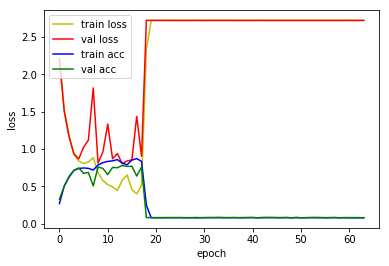

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.9159 - acc: 0.7400
Loss: 0.915921095078608 Accuracy: 0.7399792

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2043 - acc: 0.2718
Epoch 00001: val_loss improved from inf to 1.68644, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_5_conv_checkpoint/001-1.6864.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 2.2042 - acc: 0.2719 - val_loss: 1.6864 - val_acc: 0.4305
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4075 - acc: 0.5451
Epoch 00002: val_loss improved from 1.68644 to 1.57091, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_5_conv_checkpoint/002-1.5709.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.4075 - acc: 0.5451 - val_loss: 1.5709 - val_acc: 0.4903
Epoch 3/500
36800/36805 [============================>.] -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1829 - acc: 0.9403
Epoch 00027: val_loss did not improve from 0.49869
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1829 - acc: 0.9403 - val_loss: 0.6226 - val_acc: 0.8770
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1669 - acc: 0.9462
Epoch 00028: val_loss did not improve from 0.49869
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1669 - acc: 0.9462 - val_loss: 0.6548 - val_acc: 0.8626
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1636 - acc: 0.9470
Epoch 00029: val_loss did not improve from 0.49869
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1636 - acc: 0.9470 - val_loss: 0.5624 - val_acc: 0.8754
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1593 - acc: 0.9487
Epoch 00030: val_loss did not improve from 0.49869
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9678
Epoch 00057: val_loss did not improve from 0.49869
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1012 - acc: 0.9678 - val_loss: 0.6131 - val_acc: 0.8852
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0966 - acc: 0.9697
Epoch 00058: val_loss did not improve from 0.49869
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0966 - acc: 0.9697 - val_loss: 0.6504 - val_acc: 0.8819
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1009 - acc: 0.9683
Epoch 00059: val_loss did not improve from 0.49869
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1009 - acc: 0.9683 - val_loss: 0.5935 - val_acc: 0.8912
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0981 - acc: 0.9690
Epoch 00060: val_loss did not improve from 0.49869
36805/36805 [===========

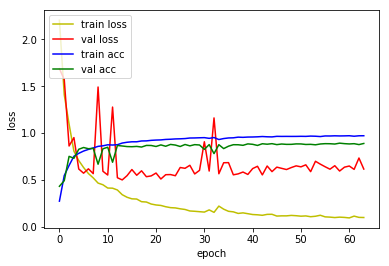

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6137 - acc: 0.8287
Loss: 0.6137015732277963 Accuracy: 0.8286604

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3677 - acc: 0.2180
Epoch 00001: val_loss improved from inf to 2.27765, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_6_conv_checkpoint/001-2.2776.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 2.3676 - acc: 0.2181 - val_loss: 2.2776 - val_acc: 0.3098
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6287 - acc: 0.4601
Epoch 00002: val_loss improved from 2.27765 to 1.31502, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_6_conv_checkpoint/002-1.3150.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.6287 - acc: 0.4601 - val_loss: 1.3150 - val_acc: 0.5819
Epoch 3/500
36800/36805 [============================>.] 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1522 - acc: 0.9502
Epoch 00026: val_loss did not improve from 0.27471
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1522 - acc: 0.9502 - val_loss: 0.3050 - val_acc: 0.9299
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1547 - acc: 0.9492
Epoch 00027: val_loss did not improve from 0.27471
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1547 - acc: 0.9491 - val_loss: 0.3296 - val_acc: 0.9241
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1425 - acc: 0.9531
Epoch 00028: val_loss did not improve from 0.27471
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1425 - acc: 0.9531 - val_loss: 0.3153 - val_acc: 0.9283
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1373 - acc: 0.9559
Epoch 00029: val_loss did not improve from 0.27471
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0697 - acc: 0.9763
Epoch 00056: val_loss did not improve from 0.27471
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0697 - acc: 0.9763 - val_loss: 0.3751 - val_acc: 0.9306
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0714 - acc: 0.9774
Epoch 00057: val_loss did not improve from 0.27471
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0713 - acc: 0.9774 - val_loss: 0.3521 - val_acc: 0.9283
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9780
Epoch 00058: val_loss did not improve from 0.27471
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0683 - acc: 0.9780 - val_loss: 0.3476 - val_acc: 0.9338
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0659 - acc: 0.9782
Epoch 00059: val_loss did not improve from 0.27471
36805/36805 [===========

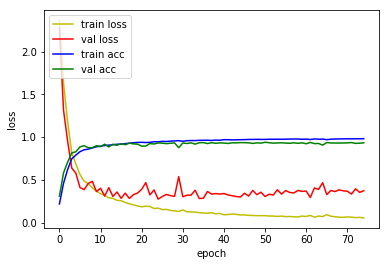

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.3392 - acc: 0.9117
Loss: 0.33917405937072026 Accuracy: 0.91173416

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5438 - acc: 0.1582
Epoch 00001: val_loss improved from inf to 1.84286, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_7_conv_checkpoint/001-1.8429.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 2.5437 - acc: 0.1582 - val_loss: 1.8429 - val_acc: 0.3986
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6750 - acc: 0.4417
Epoch 00002: val_loss improved from 1.84286 to 1.45520, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_7_conv_checkpoint/002-1.4552.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.6750 - acc: 0.4417 - val_loss: 1.4552 - val_acc: 0.5099
Epoch 3/500
36800/36805 [============================>.

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9612
Epoch 00025: val_loss did not improve from 0.15300
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1180 - acc: 0.9612 - val_loss: 0.1803 - val_acc: 0.9560
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1165 - acc: 0.9619
Epoch 00026: val_loss did not improve from 0.15300
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1165 - acc: 0.9619 - val_loss: 0.1576 - val_acc: 0.9583
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1134 - acc: 0.9632
Epoch 00027: val_loss did not improve from 0.15300
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1134 - acc: 0.9632 - val_loss: 0.2104 - val_acc: 0.9504
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1110 - acc: 0.9643
Epoch 00028: val_loss did not improve from 0.15300
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9842
Epoch 00055: val_loss did not improve from 0.15300
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0496 - acc: 0.9842 - val_loss: 0.2261 - val_acc: 0.9581
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9838
Epoch 00056: val_loss did not improve from 0.15300
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0498 - acc: 0.9838 - val_loss: 0.2133 - val_acc: 0.9595
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0493 - acc: 0.9826
Epoch 00057: val_loss did not improve from 0.15300
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0493 - acc: 0.9826 - val_loss: 0.2296 - val_acc: 0.9546
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9826
Epoch 00058: val_loss did not improve from 0.15300
36805/36805 [===========

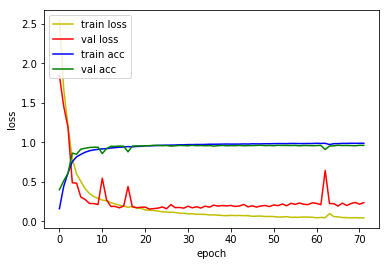

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1874 - acc: 0.9418
Loss: 0.18737413656364968 Accuracy: 0.9418484

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5933 - acc: 0.1371
Epoch 00001: val_loss improved from inf to 2.03580, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_8_conv_checkpoint/001-2.0358.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 2.5933 - acc: 0.1371 - val_loss: 2.0358 - val_acc: 0.3005
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5290 - acc: 0.4946
Epoch 00002: val_loss improved from 2.03580 to 1.45375, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_8_conv_checkpoint/002-1.4538.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.5288 - acc: 0.4946 - val_loss: 1.4538 - val_acc: 0.5488
Epoch 3/500
36800/36805 [============================>.]

36800/36805 [============================>.] - ETA: 0s - loss: 0.0756 - acc: 0.9760
Epoch 00026: val_loss did not improve from 0.10909
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0756 - acc: 0.9760 - val_loss: 0.1393 - val_acc: 0.9639
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0753 - acc: 0.9763
Epoch 00027: val_loss did not improve from 0.10909
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0754 - acc: 0.9763 - val_loss: 0.2001 - val_acc: 0.9502
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0953 - acc: 0.9690
Epoch 00028: val_loss did not improve from 0.10909
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0953 - acc: 0.9691 - val_loss: 0.1139 - val_acc: 0.9690
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0756 - acc: 0.9757
Epoch 00029: val_loss did not improve from 0.10909
36805/36805 [========================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9880
Epoch 00056: val_loss did not improve from 0.10909
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0378 - acc: 0.9880 - val_loss: 0.1546 - val_acc: 0.9674
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9903
Epoch 00057: val_loss did not improve from 0.10909
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0307 - acc: 0.9903 - val_loss: 0.1741 - val_acc: 0.9667
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9895
Epoch 00058: val_loss did not improve from 0.10909
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0336 - acc: 0.9895 - val_loss: 0.1679 - val_acc: 0.9679
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9917
Epoch 00059: val_loss did not improve from 0.10909
36805/36805 [===========

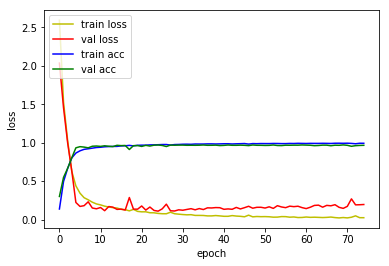

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1427 - acc: 0.9599
Loss: 0.1427228100033069 Accuracy: 0.95991695

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5189 - acc: 0.1624
Epoch 00001: val_loss improved from inf to 1.62348, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_9_conv_checkpoint/001-1.6235.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 2.5188 - acc: 0.1625 - val_loss: 1.6235 - val_acc: 0.4619
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2368 - acc: 0.5981
Epoch 00002: val_loss improved from 1.62348 to 1.06676, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_SGD_9_conv_checkpoint/002-1.0668.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.2367 - acc: 0.5982 - val_loss: 1.0668 - val_acc: 0.6541
Epoch 3/500
36800/36805 [============================>.]

36800/36805 [============================>.] - ETA: 0s - loss: 0.0505 - acc: 0.9841
Epoch 00026: val_loss did not improve from 0.11328
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0505 - acc: 0.9841 - val_loss: 0.1251 - val_acc: 0.9700
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9848
Epoch 00027: val_loss did not improve from 0.11328
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0451 - acc: 0.9848 - val_loss: 0.1233 - val_acc: 0.9686
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.9849
Epoch 00028: val_loss did not improve from 0.11328
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0452 - acc: 0.9849 - val_loss: 0.1417 - val_acc: 0.9667
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9869
Epoch 00029: val_loss did not improve from 0.11328
36805/36805 [========================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9940
Epoch 00056: val_loss did not improve from 0.11328
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0201 - acc: 0.9940 - val_loss: 0.1666 - val_acc: 0.9690
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9937
Epoch 00057: val_loss did not improve from 0.11328
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0208 - acc: 0.9937 - val_loss: 0.2054 - val_acc: 0.9637
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9936
Epoch 00058: val_loss did not improve from 0.11328
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0210 - acc: 0.9936 - val_loss: 0.1696 - val_acc: 0.9674
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9946
Epoch 00059: val_loss did not improve from 0.11328
36805/36805 [===========

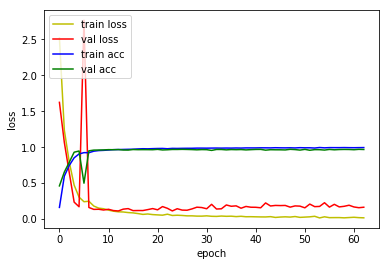

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1671 - acc: 0.9545
Loss: 0.16714281618811755 Accuracy: 0.9545171



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_128_DO_075_DO_SGD'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_DO(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
                  metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO_075_DO_SGD'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_075_DO_SGD_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           3804176     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1874 - acc: 0.9418
Loss: 0.18737413656364968 Accuracy: 0.9418484

1D_CNN_custom_ch_128_DO_075_DO_SGD_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequential

In [12]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_ch_128_DO_075_DO_SGD_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           3804176     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2502 - acc: 0.9466
Loss: 0.2502010698749385 Accuracy: 0.9466251

1D_CNN_custom_ch_128_DO_075_DO_SGD_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequential)